---
title: Day6. RNN 학습하기 실습(Hands-On)
---

## 데이터 확인

In [3]:
import pandas as pd
data = pd.read_csv("./data/Netflix_2015-2019.csv")  # 데이터 파일을 읽어옴
data.head()  # 5개의 데이터를 표시

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


## 데이터셋 전체 확인

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


## 데이터의 분포 확인

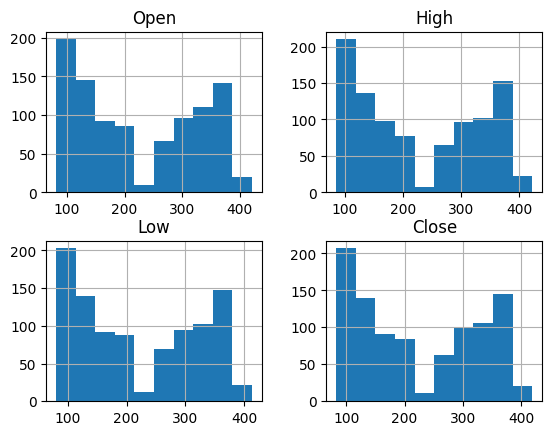

In [5]:
import matplotlib.pyplot as plt
data_used = data.iloc[:, 1:4]  # 개장가, 최고가, 최저가 추가
data_used["Close"] = data["Close"]  # 종가 추가
hist = data_used.hist()
plt.show()

## 넷플릭스 데이터셋 정의

In [6]:
import numpy as np
from torch.utils.data.dataset import Dataset

class Netflix(Dataset):
    def __init__(self):
        self.csv = pd.read_csv("./data/Netflix_2015-2019.csv")

        self.data = self.csv.iloc[:, 1:4].values
        self.data = self.data / np.max(self.data)

        self.label = data["Close"].values
        self.label = self.label / np.max(self.label)

    def __len__(self):
        return len(self.data) - 30

    def __getitem__(self, i):
        data = self.data[i:i+30]
        label = self.label[i+30]
        return data, label

In [ ]:
from torch.utils.data.dataloader import DataLoader
dataset = Netflix()
loader = DataLoader(dataset, batch_size=32)

## RNN 클래스 정의하기


In [7]:
import torch
import torch.nn as nn

class RNN(nn.Module):
   def __init__(self):
       super(RNN, self).__init__()
       self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)
       # (30,3) or (3,30)
       # batch_first => (32,30,3) / (30,3,32)
       
       # 주가를 예측하는 MLP층 정의
       self.fc1 = nn.Linear(in_features=240, out_features=64)
       self.fc2 = nn.Linear(in_features=64, out_features=1)
       self.relu = nn.ReLU() # 활성화 함수 정의

   def forward(self, x, h0):
       x, hn = self.rnn(x, h0) # RNN층의 출력

       # MLP층의 입력으로 사용될 수 있도록 모양 변경
       x = torch.reshape(x, (x.shape[0], -1))

       # MLP 층을 이용해 종가를 예측
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)

       # 예측한 종가를 1차원 벡터로 표현
       x = torch.flatten(x)

       return x

## 모델과 데이터셋 정의

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RNN().to(device)  # 모델의 정의

## 최적화 정의

In [10]:
from torch.optim.adam import Adam
optim = Adam(params=model.parameters(), lr=0.0001) # 사용할 최적화를 설정

## 학습 루프 정의

In [11]:
import tqdm
for epoch in range(200):
   iterator = tqdm.tqdm(loader)
   for data, label in iterator:
       optim.zero_grad()

       # 초기 은닉 상태
       h0 = torch.zeros(5, data.shape[0], 8).to(device)

       # 모델의 예측값
       pred = model(data.type(torch.FloatTensor).to(device), h0)

       # 손실의 계산
       loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
       
       # 오차 역전파
       loss.backward()  
       
       # 최적화 진행
       optim.step() 

       iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

torch.save(model.state_dict(), "./rnn.pth")  # 모델 저장

epoch199 loss:0.00035044897231273353: 100%|██████████| 30/30 [00:00<00:00, 114.56it/s]


## 모델 성능 평가하기

In [12]:
import matplotlib.pyplot as plt

# 예측값을 위한 데이터 로더
loader = DataLoader(dataset, batch_size=1)  

# 예측값들을 저장하는 리스트
preds = []  
total_loss = 0

with torch.no_grad():
   # 모델의 가중치 불러오기
   model.load_state_dict(torch.load("rnn.pth", map_location=device))

   for data, label in loader:
       h0 = torch.zeros(5, data.shape[0], 8).to(device)  # 초기 은닉상태 정의

       # 모델의 예측값 출력
       pred = model(data.type(torch.FloatTensor).to(device), h0)
       preds.append(pred.item())  # 예측값을 리스트에 추가
       loss = nn.MSELoss()(pred,
                           label.type(torch.FloatTensor).to(device))  # 손실계산
       total_loss += loss/len(loader)  # 손실의 평균치 계산

total_loss.item()

0.0012640039203688502

## 그림으로 확인하기

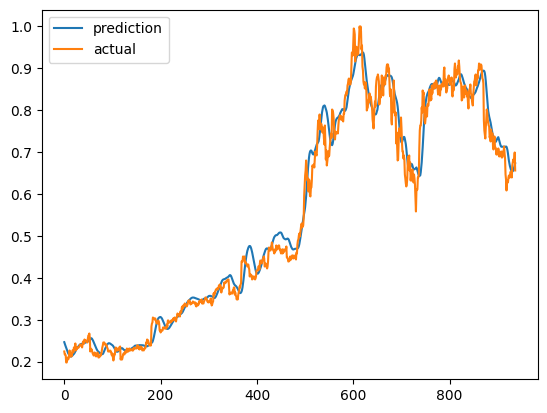

In [13]:
plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()

## 캘리포니아 집 값 예측

### Loading the data, EDA and data preparation

In [3]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
_data = fetch_california_housing()
df = pd.DataFrame(_data.data, columns=_data.feature_names)
df['target'] = _data.target

In [9]:
import torch
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, df=df):
        self.x = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1:].values

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

In [10]:
ds = MyDataset(df)
sample = next(iter(ds))
print(sample[0].shape, sample[1].shape)

torch.Size([8]) torch.Size([1])


In [12]:
from torch.utils.data import DataLoader
def prepare_loaders(df = df, index = 15640, batch_size = 512):
	# 1) Train Valids Split
    train = df[:index].reset_index(drop = True)
    valid = df[index:].reset_index(drop = True)
    
    # 2) train, valid -> MyDataset(Dataset) --> train_ds, valid_ds
    train_ds = MyDataset(train)
    valid_ds = MyDataset(valid)
    
    # 3) train_ds, valid_ds -> DataLoader -> train_loader, valid_loader
    train_loader = DataLoader(train_ds, shuffle = True, batch_size = batch_size)
    valid_loader = DataLoader(valid_ds, shuffle = False, batch_size = batch_size)
    print('DataLoader Completed')
    return train_loader, valid_loader

train_loader, valid_loader = prepare_loaders(df = df, index = 15640, batch_size = 512)

DataLoader Completed


In [13]:
sample = next(iter(train_loader))
print(sample[0].shape, sample[1].shape)

torch.Size([512, 8]) torch.Size([512, 1])


## RNN 매개변수

In [4]:
input_size = 5 # 입력의 크기
hidden_size = 8 # 은닉 상태의 크기

In [5]:
import torch
import torch.nn as nn
# (batch_size, time_steps, input_size)
# 배치 크기는 1, 10번의 시점동안 5차원의 입력 벡터가 들어가도록 텐서를 정의
inputs = torch.Tensor(1, 10, 5)

In [6]:
cell = nn.RNN(input_size, hidden_size, batch_first=True)

In [7]:
outputs, _status = cell(inputs)

In [9]:
# 10번의 시점동안 8차원의 은닉상태가 출력
print(outputs.shape) # 모든 time-step의 hidden_state

torch.Size([1, 10, 8])


In [11]:
# 다시 말해 마지막 시점의 은닉 상태의 크기를 확인해보겠습니다.
print(_status.shape) # 최종 time-step의 hidden_state

torch.Size([1, 1, 8])


In [12]:
# 이 2개인 깊은 순환 신경망의 경우, 앞서 실습했던 임의의 입력에 대해서 출력
cell = nn.RNN(input_size = 5, hidden_size = 8, num_layers = 2, batch_first=True)

In [15]:
outputs, _status = cell(inputs)

In [16]:
print(outputs.shape) # 모든 time-step의 hidden_state

torch.Size([1, 10, 8])


In [17]:
print(_status.shape) # (층의 개수, 배치 크기, 은닉 상태의 크기)

torch.Size([2, 1, 8])
